# Dynamic Equations as Vector Field Generators

$$ f(x,y) = \begin{bmatrix} \dot{x} \\ \dot{y} \end{bmatrix} = \begin{bmatrix} y \\ -x \end{bmatrix} $$

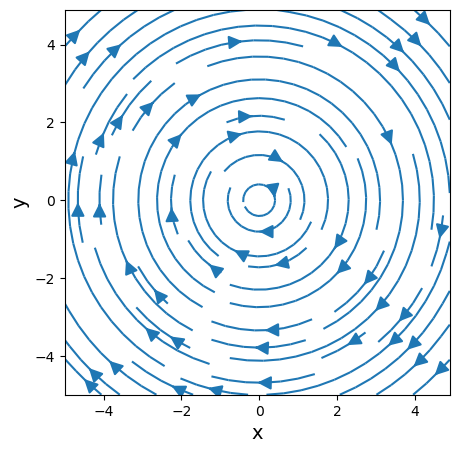

In [5]:
import numpy as np 
import matplotlib.pyplot as plt 

# 1D arrays 
x = np.arange(-5,5,0.1) 
y = np.arange(-5,5,0.1) 
  
# Meshgrid 
X, Y = np.meshgrid(x,y)

# Dynamics
def f(x, y):
    return np.array([y, -x])

# Compute vector field
X_dot, Y_dot = f(X,Y)

plt.figure(figsize=(5,5))
plt.streamplot(X, Y, X_dot, Y_dot, density=.75, arrowsize=2)
plt.xlabel('x',fontsize=14)
plt.ylabel('y',fontsize=14)
plt.gca().set_aspect('equal')
plt.show()


$$f(x,y) = \begin{bmatrix} \dot{x} \\ \dot{y} \end{bmatrix} = \begin{bmatrix} y \\ x \end{bmatrix} $$

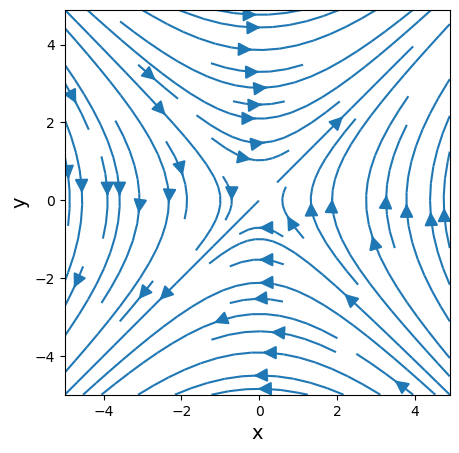

In [6]:
# Dynamics
def f(x, y):
    return np.array([y, x])

# Compute vector field
X_dot, Y_dot = f(X,Y)

plt.figure(figsize=(5,5))
plt.streamplot(X, Y, X_dot, Y_dot, density=.75, arrowsize=2)
plt.xlabel('x',fontsize=14)
plt.ylabel('y',fontsize=14)
plt.gca().set_aspect('equal')
plt.show()

$$ f(x,y) = \begin{bmatrix} \dot{x} \\ \dot{y} \end{bmatrix} = \begin{bmatrix} -x^3 \\ -y^3 \end{bmatrix} $$

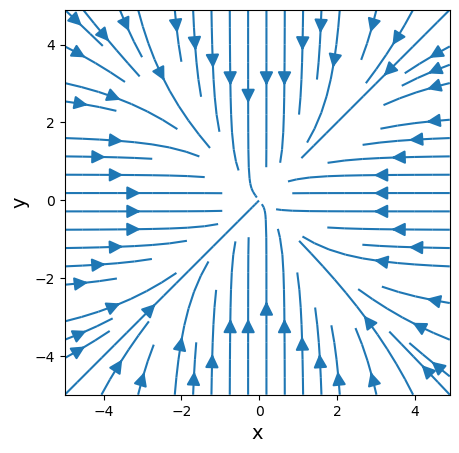

In [7]:
# Dynamics
def f(x, y):
    return np.array([-x**3, -y**3])

# Compute vector field
X_dot, Y_dot = f(X,Y)

plt.figure(figsize=(5,5))
plt.streamplot(X, Y, X_dot, Y_dot, density=.75, arrowsize=2)
plt.xlabel('x',fontsize=14)
plt.ylabel('y',fontsize=14)
plt.gca().set_aspect('equal')

plt.show()

---

# Implementing a Control Lyapunov Function (CLF)

$$\dot{x} = \begin{bmatrix} \dot{x}_1 \\ \dot{x}_2 \end{bmatrix} = f(x) + u =  \begin{bmatrix} x_2 \\ x_1 \end{bmatrix} + \begin{bmatrix} u_1 \\ u_2 \end{bmatrix} $$

$$ V(x) = \frac{1}{2} (x_1^2 + x_2^2) $$

$$\dot{V}(x,u) = \frac{\partial V}{\partial x} \frac{\partial x}{\partial t} = \begin{bmatrix} x_1 & x_2 \end{bmatrix} \begin{bmatrix} x_2 + u_1 \\ x_1 + u_2\end{bmatrix} = x_1(x_2 + u_1) + x_2(x_1 + u_2) $$

We want to choose $u$ such that for any given $x \in \mathcal{X} \subset \mathbb{R}^2$,

$$\dot{V}(x,u) + \lambda V(x) = \begin{bmatrix} x_1 & x_2 \end{bmatrix} \begin{bmatrix} u_1 \\ u_2 \end{bmatrix} + 2 x_1x_2 +\lambda V(x)  \leq 0 $$

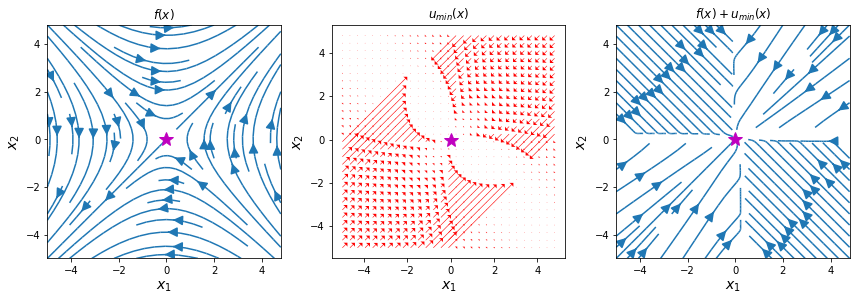

In [227]:
import cvxopt as opt
from cvxopt import matrix
from cvxopt.solvers import qp

opt.solvers.options['show_progress'] = False

# Dynamics
def f(x):
    A = np.array([[0, 1],
                  [1, 0]])
    return A@x

def V(x, x_e):
    return .5*(np.sum((x - x_e)**2))

def dVdx(x, x_e):
    return (x - x_e).T

def get_min_u(x, x_e):
    lam = 1
    Q = matrix(np.eye(2))
    q = matrix(np.zeros((2,1)))
    G = matrix(dVdx(x, x_e))
    h = matrix(-dVdx(x,x_e)@f(x)-lam*V(x,x_e))

    sol = qp(Q,q,G,h)

    return  np.array(sol['x'])

# Choose the coordinate to drive the system to
x_e = np.array([[0.0, 0.0]]).T


# 1D arrays 
x1 = np.arange(-5,5,0.35) 
x2 = np.arange(-5,5,0.35) 
  
# Meshgrid 
X1, X2 = np.meshgrid(x1,x2)

U1, U2 = np.zeros(X1.shape), np.zeros(X2.shape)
X1_dot, X2_dot = np.zeros(X1.shape), np.zeros(X2.shape)

for i in range(len(x1)):
    for j in range(len(x2)):
        x = np.array([X1[i,j],X2[i,j]])
        X1_dot[i,j], X2_dot[i,j] = f(x)
        u_min = get_min_u(x, x_e)
        U1[i,j], U2[i,j] = u_min


plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.streamplot(X1, X2, X1_dot, X2_dot, density=.75, arrowsize=2)
plt.plot(x_e[0], x_e[1], 'm*',markersize=15)
plt.xlabel(r'$x_1$',fontsize=14)
plt.ylabel(r'$x_2$',fontsize=14)
plt.title(r'$f(x)$')
plt.gca().set_aspect('equal')

plt.subplot(1,3,2)
plt.quiver(X1, X2, U1, U2, color='red',headwidth=10)
plt.plot(x_e[0], x_e[1], 'm*',markersize=15)
plt.xlabel(r'$x_1$',fontsize=14)
plt.ylabel(r'$x_2$',fontsize=14)
plt.title(r'$u_{min}(x)$')
plt.gca().set_aspect('equal')

plt.subplot(1,3,3)
plt.streamplot(X1, X2, X1_dot+U1, X2_dot+U2, density=.75, arrowsize=2)
plt.plot(x_e[0], x_e[1], 'm*',markersize=15)
plt.xlabel(r'$x_1$',fontsize=14)
plt.ylabel(r'$x_2$',fontsize=14)
plt.title(r'$f(x)+u_{min}(x)$')
plt.gca().set_aspect('equal')
plt.tight_layout()

plt.show()

# Implementing a Control Barrier Function (CBF)

Define dynamics
$$\dot{x} = \begin{bmatrix} \dot{x}_1 \\ \dot{x}_2 \end{bmatrix} = f(x) + u =  \begin{bmatrix} x_2 \\ x_1 \end{bmatrix} + \begin{bmatrix} u_1 \\ u_2 \end{bmatrix} $$

Define the safety condition

$$ h(x) = r^2 - \Vert x \Vert_2^2 $$

where $r$ is the minimum distance you want to be from the origin, making our safe set

$$ \mathcal{C} = \{x \in \mathbb{R}^2: h(x) \geq 0 \}. $$

We compute how $h(x)$ changes under the influence of the system dynamics as

$$ \dot{h}(x,u) = \frac{\partial h}{\partial x} \frac{\partial x}{\partial t} = -2\begin{bmatrix} x_1 & x_2 \end{bmatrix} (f(x) + u).$$

We want to choose the minimum $u$ such that for any given $x \in \mathcal{C} \subset \mathbb{R}^2$,

$$\dot{h}(x,u) + \alpha(h(x)) = -2\begin{bmatrix} x_1 & x_2 \end{bmatrix} \begin{bmatrix} u_1 \\ u_2 \end{bmatrix} - 2\begin{bmatrix} x_1 & x_2 \end{bmatrix} f(x) + \alpha(h(x)) \geq 0 $$

where $\alpha(\cdot)$ is a class-$\mathcal{K}$ function.


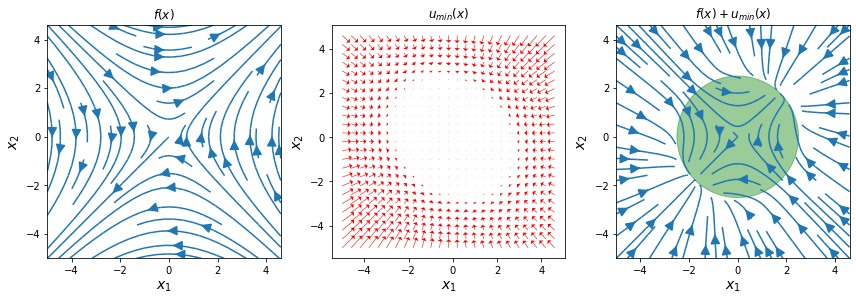

In [228]:
def h(x,r):
    return r**2 - np.sum(x**2)

def dhdx(x):
    return -2*x.T

def get_safe_u(x,r):
    alpha = 10
    Q = matrix(np.eye(2))
    q = matrix(np.zeros((2,1)))
    G = matrix(-np.atleast_2d(dhdx(x)))
    l = matrix(dhdx(x)@f(x)+alpha*h(x,r))
        
    sol = qp(Q,q,G,l)

    return  np.array(sol['x'])

# Define safety radius
r = 2.5

# 1D arrays 
x1 = np.arange(-5,5,0.4) 
x2 = np.arange(-5,5,0.4) 
  
# Meshgrid 
X1, X2 = np.meshgrid(x1,x2)


U1, U2 = np.zeros(X1.shape), np.zeros(X2.shape)
X1_dot, X2_dot = np.zeros(X1.shape), np.zeros(X2.shape)

for i in range(len(x1)):
    for j in range(len(x2)):
        x = np.array([X1[i,j],X2[i,j]])
        X1_dot[i,j], X2_dot[i,j] = f(x)
        u_min = get_safe_u(x,r)
        U1[i,j], U2[i,j] = u_min


plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.streamplot(X1, X2, X1_dot, X2_dot, density=.75, arrowsize=2)
plt.xlabel(r'$x_1$',fontsize=14)
plt.ylabel(r'$x_2$',fontsize=14)
plt.title(r'$f(x)$')
plt.gca().set_aspect('equal')

plt.subplot(1,3,2)
plt.quiver(X1, X2, U1, U2, color='red',headwidth=10)
plt.xlabel(r'$x_1$',fontsize=14)
plt.ylabel(r'$x_2$',fontsize=14)
plt.title(r'$u_{min}(x)$')
plt.gca().set_aspect('equal')

circle = plt.Circle((0,0), r, color='g', alpha=.4)
plt.subplot(1,3,3)
plt.streamplot(X1, X2, X1_dot+U1, X2_dot+U2, density=.75, arrowsize=2)
plt.xlabel(r'$x_1$',fontsize=14)
plt.ylabel(r'$x_2$',fontsize=14)
plt.title(r'$f(x)+u_{min}(x)$')
plt.gca().add_artist(circle)
plt.gca().set_aspect('equal')
plt.tight_layout()

plt.show()

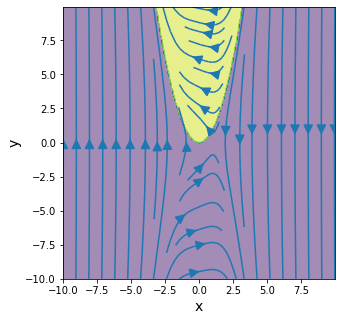

In [237]:
# Dynamics
def f(x, y):
    return np.array([-.5*y, -x**3+1])

def h(x,y):
    return y - x**2
# 1D arrays 
x = np.arange(-10,10,0.05) 
y = np.arange(-10,10,0.05) 
  
# Meshgrid 
X, Y = np.meshgrid(x,y)
Z = np.zeros(X.shape)

for i in range(len(x)):
    for j in range(len(y)):
        Z[i,j] = (h(X[i,j], Y[i,j]) >= 0)

# Compute vector field
X_dot, Y_dot = f(X,Y)

plt.figure(figsize=(5,5))
plt.streamplot(X, Y, X_dot, Y_dot, density=.75, arrowsize=2)
plt.contourf(X,Y,Z, alpha=0.5)
plt.xlabel('x',fontsize=14)
plt.ylabel('y',fontsize=14)
plt.gca().set_aspect('equal')

plt.show()